In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
limit_rows = 2000000
df = pd.read_csv('../Data/train_vers2_clean2.csv', 
                           nrows=limit_rows)
unique_ids = pd.Series(df["ncodpers"].unique())
df  = df[df.ncodpers.isin(unique_ids)]
limit_people = 1e5
unique_ids_sample= unique_ids.sample(n=limit_people)
df = df[df.ncodpers.isin(unique_ids_sample)]

/Users/MontoroMontarroso/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/MontoroMontarroso/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2572: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


In [3]:
df=df[df['fecha_dato']=='2015-01-28']

In [4]:
columns = np.append(df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values, ['age'])
df = df.ix[:, columns]

In [5]:
#df_cr = df[df['nomprov'] == 'CIUDAD REAL'].drop('nomprov', axis = 1)
#df_madrid = df[df['nomprov'] == 'MADRID'].drop('nomprov', axis = 1)
#df_badajoz = df[df['nomprov'] == 'BADAJOZ'].drop('nomprov', axis = 1)
df_spain = df[(df['age'] >=1) & (df['age'] <= 10)].drop('age', axis = 1)

In [6]:
from sklearn.cluster import KMeans

In [7]:
n_clusters = int(np.sqrt(df_spain.shape[0]))
km = KMeans(n_clusters, init = 'k-means++', max_iter=300, tol=1e-04)
labels = km.fit_predict(df_spain)
df_spain['cluster'] = labels
df_spain_reduced = df_spain.groupby(by=['cluster']).mean()

In [8]:
from sklearn.neighbors import DistanceMetric
from scipy import cluster 

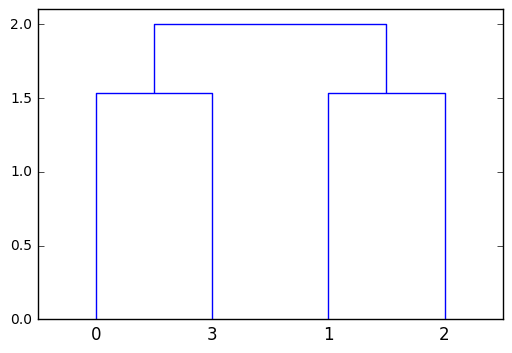

In [9]:
dist = DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(df_spain_reduced)
clusters = cluster.hierarchy.linkage(matsim, method='complete')
cluster.hierarchy.dendrogram(clusters)
plt.show()

In [10]:
from sklearn import metrics

In [11]:
#df_sample = df_spain.sample(1000)
metrics.silhouette_score(df_spain, labels)

1.0